In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)

# Define the LeNet5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# TRAIN THE MODEL ON THE DATASET
# Load MNIST data
transform = transforms.ToTensor()
full_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
# Define the size of the subset
subset_size = 1000
indices = torch.randperm(len(full_dataset))[:subset_size]
subset_dataset = Subset(full_dataset, indices)
# Create the DataLoader
data_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Instantiate the model
model = LeNet5()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
# Optimizer definition
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\Robin\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
try:
    # Load the saved model
    model_weights_path = 'models_weights/lenet5_mnist_weights.pth'
    saved_weights = torch.load(model_weights_path)
    # Create a new model and load the saved weights
    model = LeNet5()
    model.load_state_dict(saved_weights)

except:
    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
        
            labels = labels

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

    model_weights_path = 'models_weights/lenet2_mnist_weights_2.pth'
    torch.save(model.state_dict(), model_weights_path)
    

inputs, labels  = next(iter(data_loader))
MinimizerVector = Params2Vec(model.parameters())

## norm of the minmizer vector
#norm_minimizer = torch.norm(MinimizerVector)
## Filterwise normalisation :: u1 <- u1 * ||w1|| / ||u1|| from paper
#param_directionx = F.normalize((torch.rand(MinimizerVector.size()) * 2 - 1).type(torch.FloatTensor) , p=2, dim=0) * norm_minimizer
#param_directiony = F.normalize((torch.rand(MinimizerVector.size()) * 2 - 1).type(torch.FloatTensor) , p=2, dim=0) * norm_minimizer


# Filterwise normalisation :: u1 <- u1 * ||w1|| / ||u1|| from paper
param_directionx =  (torch.rand(MinimizerVector.size()) * 2 - 1).type(torch.FloatTensor)
param_directionx = F.normalize(torch.matmul(torch.diag(MinimizerVector), param_directionx), p=2, dim=0) # Vectorwise normalisation
param_directiony = (torch.rand(MinimizerVector.size()) * 2 - 1).type(torch.FloatTensor) 
param_directiony = F.normalize(torch.matmul(torch.diag(MinimizerVector), param_directiony), p=2, dim=0) # Vectorwise normalisation


print(f'direction x : {param_directionx} and direction y : {param_directiony}')

direction x : tensor([-7.4767e-03, -7.5638e-06,  5.1361e-03,  ...,  4.8019e-04,
         1.3925e-03, -2.9037e-03], grad_fn=<DivBackward0>) and direction y : tensor([ 1.3219e-02,  1.0289e-05, -3.3812e-03,  ...,  2.8436e-04,
         2.9706e-03, -2.2891e-03], grad_fn=<DivBackward0>)


In [16]:
# landscape parameters
points = 15
range_val = 5

x_grid = np.linspace(-1.0, 1.0, num=points)**3 *  range_val
y_grid = np.linspace(-1.0, 1.0, num=points)**3 *  range_val
loss_grid = np.empty([points, points])


for idx_x, x in enumerate(x_grid):
    for idx_y, y in enumerate(y_grid):
        new_parameters = MinimizerVector +  x*param_directionx + y*param_directiony
        # Convert the tensor back into parameters
        Vec2Params(new_parameters, model.parameters())

        # print the parameters of the model
        # print(Params2Vec(model.parameters())[0])
        
        # Calculate the loss for these weights for 15 batches
        batch_number = 0
        loss_sum = 0
        
        # Compute the loss on multiple batches
        while True:
            inputs, labels  = next(iter(data_loader))
            batch_number += 1
            pred = model(inputs)
            loss = criterion(pred, labels)
            loss_sum += loss
            if batch_number % 15 == 0:
                loss_grid[idx_x, idx_y] = loss_sum/15
                break
            


In [17]:
loss_grid.max()

0.7436270117759705

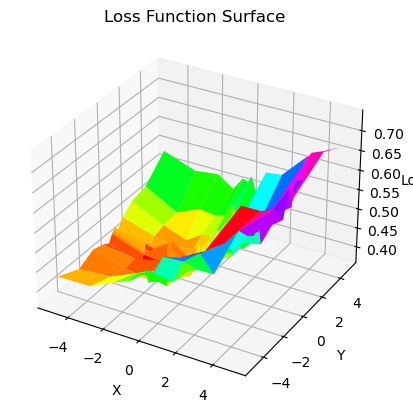

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data for the loss function
x = x_grid
y = y_grid
X, Y = np.meshgrid(x, y)
Z =  loss_grid 
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='hsv', edgecolor = 'None')



# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Loss')
ax.set_title('Loss Function Surface')

# Show the plot
plt.show()

In [ ]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)
def state_dict_to_vector(state_dict):
    vec = []
    for param_tensor in state_dict:
        vec.append(state_dict[param_tensor].view(-1))
    return torch.cat(vec)
param1 = state_dict_to_vector(loss_surface.new_weight_list[0])
param2 = state_dict_to_vector(loss_surface.new_weight_list[1])

